In [4]:
import pandas as pd
from datetime import date
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import urllib.request
import codecs
pd.options.display.max_rows=1000
%matplotlib inline

## I. Data Extraction

In [128]:
#Copy desired dates from website: http://web.mta.info/developers/turnstile.html
raw_dates_txt = """
Saturday, May 25, 2019
Saturday, May 18, 2019
"""

In [129]:
date_obj_lst = [datetime.strftime(datetime.strptime(line, '%A, %B %d, %Y'), '%y%m%d') for line in raw_dates_txt.split('\n') if line]
    
turnstile_url = ['http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + date + '.txt' for date in date_obj_lst]

with open('turnstile_data', 'w') as outfile:
    writer = csv.writer(outfile, delimiter=',')
    ftpstream = urllib.request.urlopen(turnstile_url[0])
    csvfile = csv.reader(codecs.iterdecode(ftpstream, 'utf-8'))
    for line in csvfile:
        writer.writerow(line)    
    for url in turnstile_url[1:]:
        ftpstream = urllib.request.urlopen(url)
        csvfile = csv.reader(codecs.iterdecode(ftpstream, 'utf-8'))
        firstline = True
        for line in csvfile:
            if firstline:    #skip first line
                firstline = False
                continue
            writer.writerow(line)

In [130]:
with open('turnstile_data') as input:
    turnstile = pd.read_csv(input)

In [131]:
turnstile.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,00:00:00,REGULAR,7062481,2393489
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,04:00:00,REGULAR,7062505,2393492
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,08:00:00,REGULAR,7062529,2393526
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,12:00:00,REGULAR,7062627,2393612
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,16:00:00,RECOVR AUD,7062835,2393662


In [8]:
turnstile.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [9]:
turnstile.isna().sum()

C/A                                                                     0
UNIT                                                                    0
SCP                                                                     0
STATION                                                                 0
LINENAME                                                                0
DIVISION                                                                0
DATE                                                                    0
TIME                                                                    0
DESC                                                                    0
ENTRIES                                                                 0
EXITS                                                                   0
dtype: int64

In [10]:
turnstile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027180 entries, 0 to 1027179
Data columns (total 11 columns):
C/A                                                                     1027180 non-null object
UNIT                                                                    1027180 non-null object
SCP                                                                     1027180 non-null object
STATION                                                                 1027180 non-null object
LINENAME                                                                1027180 non-null object
DIVISION                                                                1027180 non-null object
DATE                                                                    1027180 non-null object
TIME                                                                    1027180 non-null object
DESC                                                                    1027180 non-null object
ENTRIES                

## II. Data Cleansing

### 1. Clean Column Names

In [132]:
turnstile.columns=[col.strip() for col in turnstile.columns]
turnstile.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

### 2. Remove Inconsistent Text

In [133]:
#station name cleansing
#the strip() removes characters from both left and right based on the argument
turnstile['STATION']=[name.strip() for name in turnstile.STATION]
turnstile['STATION'] = turnstile['STATION'].str.replace('STREET', 'ST')
turnstile['STATION'] = turnstile['STATION'].str.replace('AVE', 'AV')

### 3. Change DataType to DateTime

In [134]:
turnstile['DATE & TIME']=turnstile['DATE'] +' '+ turnstile['TIME']
turnstile.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE & TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,00:00:00,REGULAR,7062481,2393489,05/18/2019 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,04:00:00,REGULAR,7062505,2393492,05/18/2019 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,08:00:00,REGULAR,7062529,2393526,05/18/2019 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,12:00:00,REGULAR,7062627,2393612,05/18/2019 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,16:00:00,RECOVR AUD,7062835,2393662,05/18/2019 16:00:00


In [135]:
turnstile['DATE & TIME'] = pd.to_datetime(turnstile['DATE & TIME'])

### 4. Data Disaggregation 

In [136]:
#Since the entry data we have is cumulative, 
#we want to combine ControlArea/UNIT/STATION together
#and calculate the actual numbers of entries per turnstile
#for each day, add the counts from each turnstile belonging to that combo.
turnstile['ENTRIES DIFF']=turnstile.groupby(['C/A','UNIT','STATION'])['ENTRIES'].diff()
turnstile['EXITS DIFF']=turnstile.groupby(['C/A','UNIT','STATION'])['EXITS'].diff()

In [16]:
#check how many nan and negative entry numbers do we have in total
turnstile[(turnstile['ENTRIES DIFF']<0) | (turnstile['EXITS DIFF']<0)].count()

C/A             27235
UNIT            27235
SCP             27235
STATION         27235
LINENAME        27235
DIVISION        27235
DATE            27235
TIME            27235
DESC            27235
ENTRIES         27235
EXITS           27235
DATE & TIME     27235
DAY OF WEEK     27235
ENTRIES DIFF    27235
EXITS DIFF      27235
dtype: int64

In [18]:
turnstile.isna().sum()

C/A               0
UNIT              0
SCP               0
STATION           0
LINENAME          0
DIVISION          0
DATE              0
TIME              0
DESC              0
ENTRIES           0
EXITS             0
DATE & TIME       0
DAY OF WEEK       0
ENTRIES DIFF    746
EXITS DIFF      746
dtype: int64

In [137]:
#The total number of negative entries and na entries 
#is small, so we can drop them
turnstile=turnstile.drop(turnstile[turnstile['ENTRIES DIFF'] < 0].index)
turnstile=turnstile.drop(turnstile[turnstile['EXITS DIFF'] < 0].index)
turnstile=turnstile.dropna()

In [138]:
#We can now remove the culmulative entries and exits data
turnstile=turnstile.drop(['ENTRIES','EXITS'],axis=1)

### 5. Remove Outliners

In [21]:
turnstile.describe()

,ENTRIES DIFF,EXITS DIFF
count,9.991990e+05,9.991990e+05
mean,7.996694e+05,6.789899e+05
std,3.103932e+07,2.828373e+07
min,0.000000e+00,0.000000e+00
25%,1.000000e+01,9.000000e+00
50%,7.500000e+01,5.400000e+01
75%,2.420000e+02,1.710000e+02
max,2.121026e+09,2.118755e+09


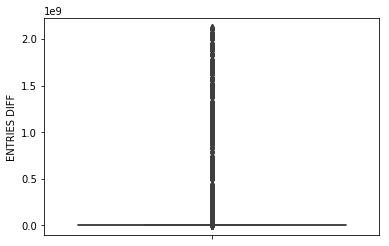

In [44]:
sns.boxplot(turnstile['ENTRIES DIFF'],orient='v')

In [139]:
q25_1,q50_1,q75_1=np.percentile(turnstile['ENTRIES DIFF'],[25,50,75])
iqr_1=q75_1-q25_1
iqr_1

239.0

In [140]:
q25_2,q50_2,q75_2=np.percentile(turnstile['EXITS DIFF'],[25,50,75])
iqr_2=q75_2-q25_2
iqr_2

166.0

In [141]:
max_entry=q75_1+1.5*(iqr_1)
max_exit=q75_2+1.5*(iqr_2)

In [22]:
#calculate how many outliner do we have in entry data
turnstile[turnstile['ENTRIES DIFF']> max_entry].count()

C/A             73367
UNIT            73367
SCP             73367
STATION         73367
LINENAME        73367
DIVISION        73367
DATE            73367
TIME            73367
DESC            73367
DATE & TIME     73367
DAY OF WEEK     73367
ENTRIES DIFF    73367
EXITS DIFF      73367
dtype: int64

In [27]:
#calculate how many outliner do we have in exit data
turnstile[turnstile['EXITS DIFF']> max_exit].count()

C/A             90133
UNIT            90133
SCP             90133
STATION         90133
LINENAME        90133
DIVISION        90133
DATE            90133
TIME            90133
DESC            90133
DATE & TIME     90133
DAY OF WEEK     90133
ENTRIES DIFF    90133
EXITS DIFF      90133
dtype: int64

In [142]:
turnstile=turnstile.drop(turnstile[turnstile['ENTRIES DIFF']>max_entry].index)
turnstile=turnstile.drop(turnstile[turnstile['EXITS DIFF']>max_exit].index)

### 6. Add Total Traffic column

In [143]:
turnstile['Total Traffic']=turnstile['ENTRIES DIFF']+turnstile['EXITS DIFF']
turnstile.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,DATE & TIME,ENTRIES DIFF,EXITS DIFF,Total Traffic
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,04:00:00,REGULAR,2019-05-18 04:00:00,24.0,3.0,27.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,08:00:00,REGULAR,2019-05-18 08:00:00,24.0,34.0,58.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,12:00:00,REGULAR,2019-05-18 12:00:00,98.0,86.0,184.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,16:00:00,RECOVR AUD,2019-05-18 16:00:00,208.0,50.0,258.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/18/2019,20:00:00,REGULAR,2019-05-18 20:00:00,262.0,34.0,296.0


## III. Data Analysis/Visualization

1. Total Daily Entries per DAY OF WEEK

From the result, we can have a general idea about which
day of the week have the most total entries. 

In [120]:
df=turnstile.groupby(['DATE'])['Total Traffic']\
     .sum()\
     .reset_index(name='TOTAL ENTRIES per DAY')\
     .sort_values(['TOTAL ENTRIES per DAY'], ascending=False)

In [121]:
df=turnstile.groupby(['DATE'])['Total Traffic']\
     .sum()\
     .reset_index(name='TOTAL ENTRIES per DAY')
df.head()

,DATE,TOTAL ENTRIES per DAY
0,03/30/2019,3701760.0
1,03/31/2019,3818869.0
2,04/01/2019,4843241.0
3,04/02/2019,5027469.0
4,04/03/2019,5048164.0


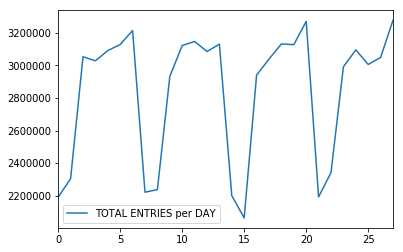

In [53]:
df.plot()

2. Total Entries per Station

This gives us an idea of which stations are the top 10 most busiest stations. 

Need a plot here

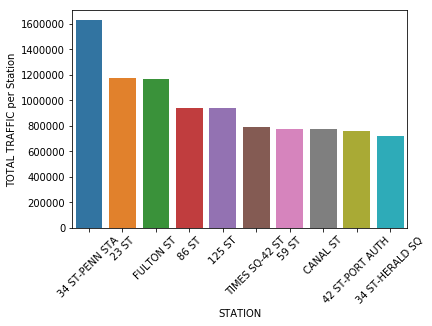

In [144]:
BUSY_STATION=turnstile.groupby(['STATION'])['Total Traffic']\
     .sum()\
     .reset_index(name='TOTAL TRAFFIC per Station')\
     .sort_values(['TOTAL TRAFFIC per Station'], ascending=False)
df=BUSY_STATION.head(10)
g=sns.barplot(x="STATION", y="TOTAL TRAFFIC per Station", data=df);
g.set_xticklabels(g.get_xticklabels(), rotation=45);


3. Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [60]:
df=turnstile.groupby(['STATION','DAY OF WEEK'])['ENTRIES DIFF']\
     .sum()\
     .reset_index(name='TOTAL ENTRIES per DAY')
df.head()

,STATION,DAY OF WEEK,TOTAL ENTRIES per DAY
0,1 AV,Friday,27280.0
1,1 AV,Monday,26616.0
2,1 AV,Saturday,13031.0
3,1 AV,Sunday,19332.0
4,1 AV,Thursday,27088.0


In [92]:
station_day = ['STATION', 'DAY OF WEEK']
station_day_df = (df.set_index(station_day)  
                           .sort_index())
#                            .sort_values(['TOTAL ENTRIES per DAY'], ascending=False))
station_day_df

TOTAL ENTRIES per DAY
STATION         DAY OF WEEK                       
1 AV            Friday                     27280.0
                Monday                     26616.0
                Saturday                   13031.0
                Sunday                     19332.0
                Thursday                   27088.0
                Tuesday                    27318.0
                Wednesday                  27727.0
103 ST          Friday                     69756.0
                Monday                     72682.0
                Saturday                   57156.0
                Sunday                     57953.0
                Thursday                   64380.0
                Tuesday                    67320.0
                Wednesday                  65262.0
103 ST-CORONA   Friday                     42376.0
                Monday                     38896.0
                Saturday                   46137.0
                Sunday                     48835.0
                Thursday                   33315.0
                Tuesday                    36984.0
                Wednesday                  31579.0
104 ST          Friday                     17437.0
                Monday                     14310.0
                Saturday                    6479.0
                Sunday                      5198.0
                Thursday                   17300.0
                Tuesday                    17666.0
                Wednesday                  18137.0
110 ST          Friday                     26368.0
                Monday                     29610.0
                Saturday                   22965.0
                Sunday                     25877.0
                Thursday                   29292.0
                Tuesday                    30929.0
                Wednesday                  27246.0
111 ST          Friday                     38487.0
                Monday                     37626.0
                Saturday                   41743.0
                Sunday                     39841.0
                Thursday                   36856.0
                Tuesday                    36705.0
                Wednesday                  35277.0
116 ST          Friday                    135057.0
                Monday                    120611.0
                Saturday                   88157.0
                Sunday                     92760.0
                Thursday                  134006.0
                Tuesday                   129648.0
                Wednesday                 129999.0
116 ST-COLUMBIA Friday                     25170.0
                Monday                     18556.0
                Saturday                    9097.0
                Sunday                      9130.0
                Thursday                   16166.0
                Tuesday                    17618.0
                Wednesday                  17455.0
121 ST          Friday                     12391.0
                Monday                      9813.0
                Saturday                    3726.0
                Sunday                      3241.0
                Thursday                   12171.0
                Tuesday                    12200.0
                Wednesday                  12754.0
125 ST          Friday                    172053.0
                Monday                    177730.0
                Saturday                  129942.0
                Sunday                    143690.0
                Thursday                  182769.0
                Tuesday                   187141.0
                Wednesday                 179702.0
135 ST          Friday                     78228.0
                Monday                     71678.0
                Saturday                   57896.0
                Sunday                     55221.0
                Thursday                   77870.0
                Tuesday                    75886.0
                Wednesday                  78939.0


In [93]:
from pylab import rcParams
# rcParams['figure.figsize'] = 5, 10
# station_day_df.unstack(level=0).plot(kind='line',figsize=(100, 100), subplots=True);

In [94]:
df_34_ST_PENN_STA = station_day_df.loc['34 ST-PENN STA']
df_23_ST = station_day_df.loc['23 ST']
df_FULTON_ST = station_day_df.loc['FULTON ST']
df_86_ST = station_day_df.loc['86 ST']
df_125_ST = station_day_df.loc['125 ST']
df_42_ST_PORT_AUTH = station_day_df.loc['42 ST-PORT AUTH']


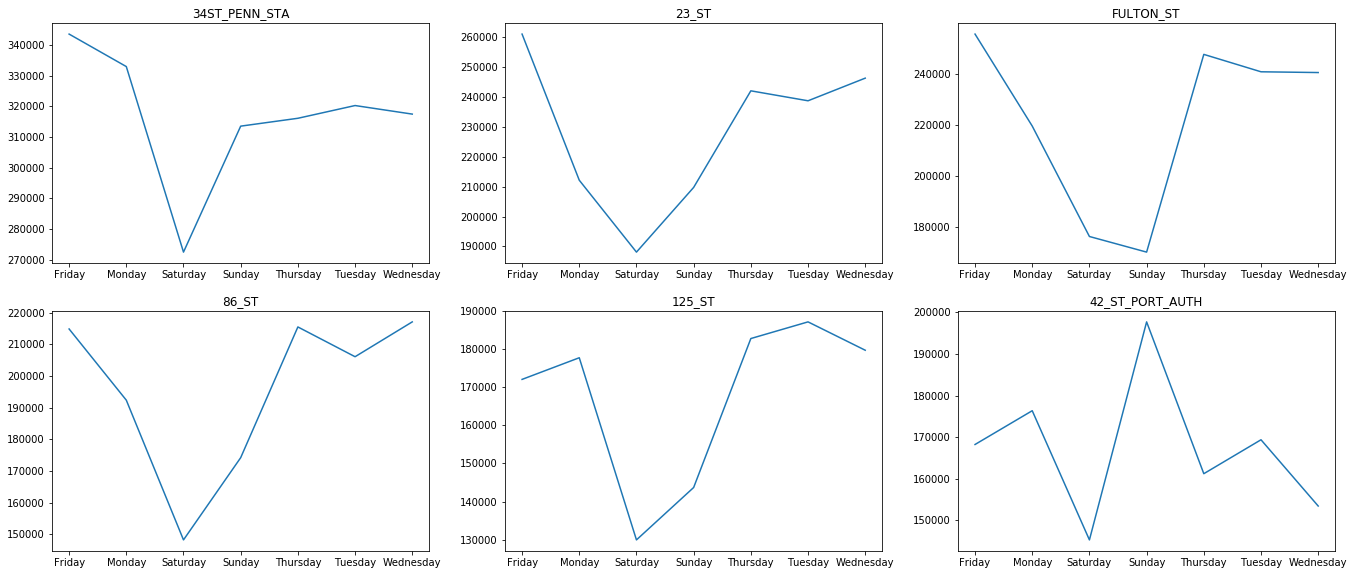

In [95]:
plt.figure(figsize=[23,15])
plt.subplot(3,3,1)
plt.plot(df_34_ST_PENN_STA)
plt.title('34ST_PENN_STA')

plt.subplot(3,3,2)
plt.plot(df_23_ST)
plt.title('23_ST')

plt.subplot(3,3,3)
plt.plot(df_FULTON_ST)
plt.title('FULTON_ST')

plt.subplot(3,3,4)
plt.plot(df_86_ST)
plt.title('86_ST')

plt.subplot(3,3,5)
plt.plot(df_125_ST)
plt.title('125_ST')

plt.subplot(3,3,6)
plt.plot(df_42_ST_PORT_AUTH)
plt.title('42_ST_PORT_AUTH');
#Question: Is it possible to change the x axis to be the same for each graph. or is it 